In [1]:
import pandas as pd
import numpy as np
import quandl, math, datetime
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import pickle
from datetime import datetime as date

In [2]:
dataset = quandl.get('GOOG/NASDAQ_TSLA',start_date="2013-01-01")
print(dataset.head())
print(dataset.tail())

             Open   High    Low  Close     Volume
Date                                             
2013-01-02  35.00  35.45  34.70  35.36  1194710.0
2013-01-03  35.18  35.45  34.75  34.77   741941.0
2013-01-04  34.80  34.80  33.92  34.40   673993.0
2013-01-07  34.80  34.80  33.90  34.34   441909.0
2013-01-08  34.50  34.50  33.11  33.68  1283985.0
              Open    High     Low   Close     Volume
Date                                                 
2017-01-17  236.70  239.96  234.37  235.58  4617522.0
2017-01-18  236.65  239.71  235.58  238.36  3768967.0
2017-01-19  247.25  248.68  240.75  243.76  7732303.0
2017-01-20  245.46  246.00  243.01  244.73  4204275.0
2017-01-23  245.85  250.89  245.50  248.92  6262938.0


In [3]:
dataset['Average10'] = dataset['Close'].rolling(10).mean()
dataset['Average50'] = dataset['Close'].rolling(50).mean()

['bmh', 'fivethirtyeight', 'dark_background', 'seaborn-ticks', 'seaborn-white', 'seaborn-bright', 'seaborn-whitegrid', 'grayscale', 'seaborn-talk', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-deep', 'classic', 'seaborn-darkgrid', 'seaborn-notebook', 'seaborn-paper', 'seaborn-muted', 'seaborn-pastel', 'ggplot', 'seaborn-colorblind', 'seaborn-poster']


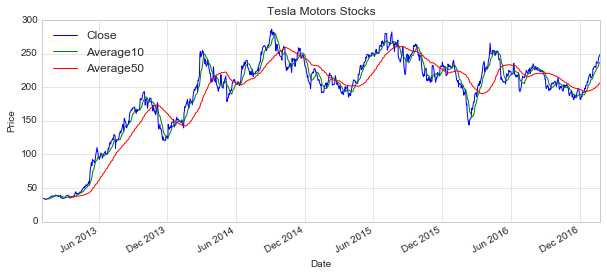

In [4]:
print(plt.style.available)
style.use('seaborn-whitegrid')
dataset[['Close','Average10','Average50']].plot(subplots=False, figsize=(10, 4),title = 'Tesla Motors Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [5]:
dataset = dataset.drop(['Average10','Average50'],1,errors='ignore')
print(dataset.head())

             Open   High    Low  Close     Volume
Date                                             
2013-01-02  35.00  35.45  34.70  35.36  1194710.0
2013-01-03  35.18  35.45  34.75  34.77   741941.0
2013-01-04  34.80  34.80  33.92  34.40   673993.0
2013-01-07  34.80  34.80  33.90  34.34   441909.0
2013-01-08  34.50  34.50  33.11  33.68  1283985.0


In [6]:
dataset.isnull().values.any()

False

In [7]:
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
dataset = pd.DataFrame(imp.fit_transform(dataset),index = dataset.index, columns = dataset.columns)

In [9]:
forecast_vector = 'Close'
lag_pct = 0.03
forecast_shift = int(math.ceil(lag_pct*len(dataset)))
print(forecast_shift)

31


In [10]:
dataset['Label'] = dataset[forecast_vector].shift(-forecast_shift)

X = np.array(dataset.drop(['Label'],1))
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X_late = X[-forecast_shift:]
X = X[:-forecast_shift]
dataset.dropna(inplace=True)
Y = np.array(dataset['Label'])

print(len(X),len(Y))

991 991


In [26]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X,Y,test_size=0.2)
clf = svm.SVR(kernel='linear')
clf.fit(X_train,Y_train)
accuracy = clf.score(X_test,Y_test)
print(accuracy)

0.733503662132


In [12]:
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)

In [13]:
last_date = dataset.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
first_forecast = date.fromtimestamp(next_unix)
last_forecast = date.fromtimestamp(last_unix+(one_day*forecast_shift))

dates = pd.date_range(first_forecast, periods=forecast_shift)

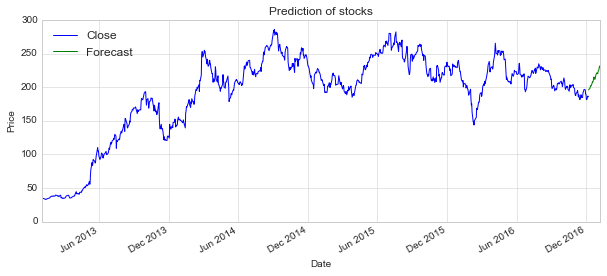

In [14]:
forecast_set = pd.DataFrame(clf.predict(X_late),columns=['Forecast'],index=dates)
dataset = dataset.append(forecast_set)
dataset[['Close','Forecast']].plot(subplots=False, figsize=(10, 4),title = 'Prediction of stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()